In [14]:
import math
import torch
import random

# Micrograd vs Pytorch

We'll start by verify if all we did with MicroGrad it's correct with Pytorch

In [19]:
class Value:
    """
    stores a single scalar value and its gradient
    """

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad 
        out._backward = _backward

        return out
    
    def __radd__(self,other):
        return self + other

    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data 
            other.grad += self.data * out.grad 
        out._backward = _backward

        return out 
    
    def __rmul__(self,other):
        return self * other
    
    #we add div
    def __truediv__(self,other):
        return self * other**-1
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), 'f**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.grad * out.data 
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                visited.add(v)
            topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [20]:
# I've just copy/paste this function
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [21]:
x1 = torch.Tensor([2.0]).double()                               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                               ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()                 ; x2.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

In [22]:
print(o.data.item())
o.backward()

0.7071066904050358


In [23]:
print('-------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

-------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [24]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [25]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [26]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' #combinaison of function without activation fonction (tanh for our cases)

o = n.tanh();o.label='o'

In [27]:
o.backward()

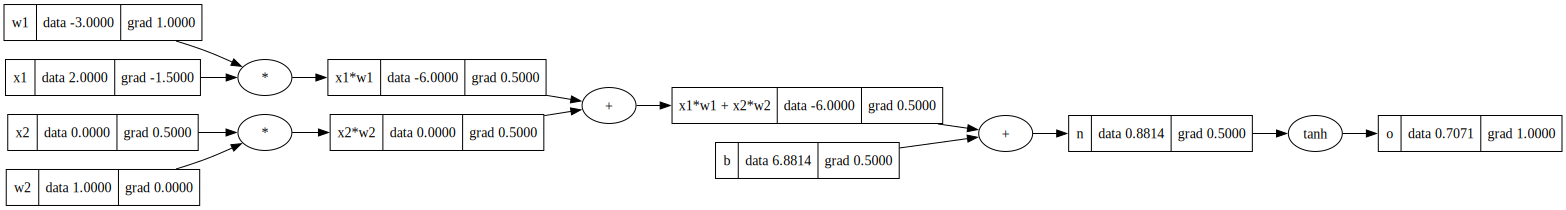

In [28]:
draw_dot(o)

yay !!!!!!!!!!!

# Build our Neural Network

In [29]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum(wi*xi for wi,xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    

In [31]:
x = [2.0,3.0]
n = Neuron(2)
n(x)

Value(data=0.9490873363613267)

to be more effecient

In [32]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)),self.b)
        out = act.tanh()
        return out
    

In [34]:
x = [2.0,3.0]
n = Neuron(2)
n(x)

Value(data=-0.8834573238592515)

For now we have a Neuron
We'll now define a layer

In [39]:
class Layer:

    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]

        return outs

In [40]:
x = [2.0, 3.0]
n = Layer(2,4)

In [41]:
n(x)

[Value(data=-0.8548377832599302),
 Value(data=0.3602817580597523),
 Value(data=0.9981266216647414),
 Value(data=-0.39369555904772324)]

Excellent

For now, we can define MLP

In [44]:
class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [46]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])

In [48]:
n(x)

[Value(data=0.6222780339488603)]

We can make our class NICEEE

In [49]:
class Layer:

    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]

        return outs[0] if len(outs) == 1 else outs

class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [50]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.7165765883702733)

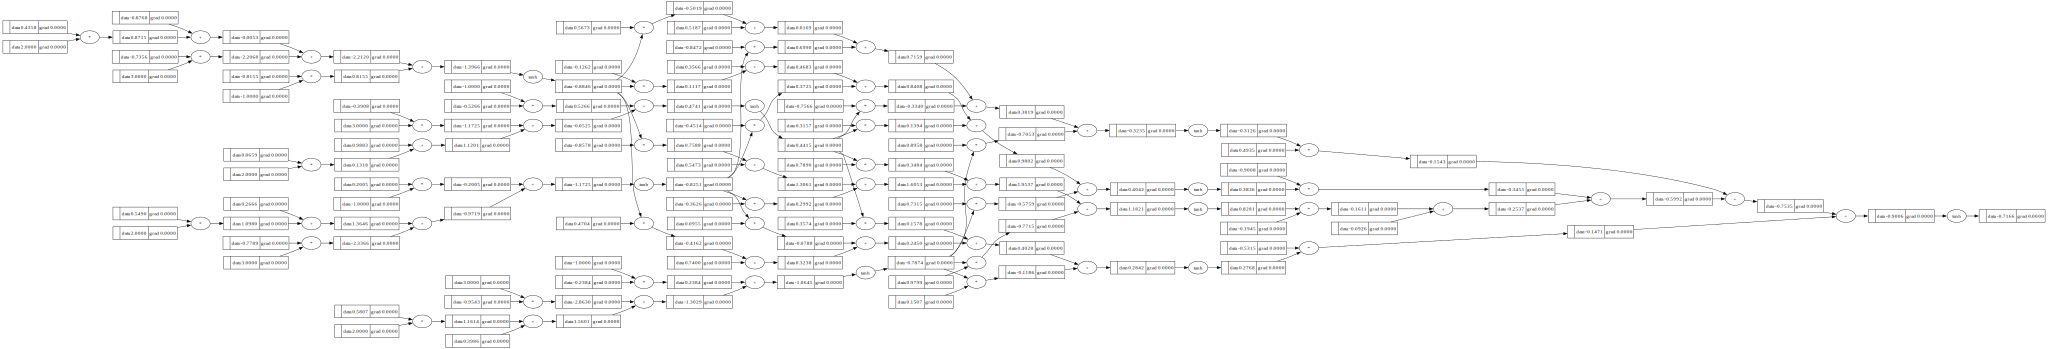

In [52]:
draw_dot(n(x))